### Setup

This cell loads the required libraries, sets the dataset paths, and defines basic training parameters.  
It also checks whether a GPU is available and selects the device accordingly.


In [1]:
# basic imports and setup

import os
import time
from pathlib import Path

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms as T
from PIL import Image
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# makes CUDA errors easier to trace
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# dataset location
RAW_DATA_ROOT = Path(
    r"C:\Users\TUSHAR\2025-26\PROJECTS\pcb_defect_detection\data\raw\DeepPCB"
)

# train / test split files
train_split = RAW_DATA_ROOT / "trainval.txt"
test_split  = RAW_DATA_ROOT / "test.txt"

# training params
IMAGE_SIZE   = 224
BATCH_SIZE   = 32
NUM_WORKERS  = 0
PIN_MEMORY   = False
LR           = 1e-4
WEIGHT_DECAY = 1e-5
NUM_EPOCHS   = 2

# pick device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))
else:
    print("cpu")


NVIDIA GeForce RTX 4060 Laptop GPU


### Dataset and transforms

- Images are resized to a fixed input size before being fed to the model.
- For training data, random horizontal and vertical flips are applied.
- Small random rotations are used to handle orientation variations.
- Color jitter is applied to introduce brightness and contrast variation.
- Images are converted to tensors and normalized using ImageNet statistics.
- Validation and test images use only resizing and normalization.
- A custom dataset reads image paths and bounding box annotations from split files.
- Defect regions are cropped using bounding box coordinates.
- Each cropped patch is returned with its corresponding class label.


In [2]:
# image transforms for training and validation

from torchvision import transforms as T
from PIL import Image

# used during training
train_transform = T.Compose([
    T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip(),
    T.RandomRotation(15),
    T.ColorJitter(
        brightness=0.2,
        contrast=0.2,
        saturation=0.2,
        hue=0.1
    ),
    T.ToTensor(),
    T.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# used for validation / testing
val_transform = T.Compose([
    T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    T.ToTensor(),
    T.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


# dataset for DeepPCB patch-based data
class DeepPCBPatchDataset(Dataset):

    def __init__(self, root_dir, split_file, transform=None):
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.samples = []

        # split file has image path and annotation path per line
        with open(split_file, "r") as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) != 2:
                    continue

                img_rel, ann_rel = parts
                img_path = self.root_dir / img_rel
                ann_path = self.root_dir / ann_rel

                # handle renamed images if present
                if not img_path.exists():
                    alt_img_path = img_path.with_name(
                        img_path.stem + "_temp" + img_path.suffix
                    )
                    if alt_img_path.exists():
                        img_path = alt_img_path
                    else:
                        continue

                if not ann_path.exists():
                    continue

                # read bounding boxes from annotation file
                with open(ann_path, "r") as af:
                    for line in af:
                        x_min, y_min, x_max, y_max, cls_id = map(
                            int, line.strip().split()
                        )

                        # store one patch per bounding box
                        self.samples.append(
                            (img_path, (x_min, y_min, x_max, y_max), cls_id - 1)
                        )

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, bbox, cls_id = self.samples[idx]

        img = Image.open(img_path).convert("RGB")

        # crop defect area
        x_min, y_min, x_max, y_max = bbox
        patch = img.crop((x_min, y_min, x_max, y_max))

        if self.transform:
            patch = self.transform(patch)

        return patch.float(), torch.tensor(cls_id, dtype=torch.long)


### Dataset loading 

- Initialize training and validation datasets using the DeepPCB patch dataset.
- Create DataLoaders for batch-wise data loading.
- Verify dataset integrity by checking batch shapes and label values.
- Visually inspect random defect patches to confirm correct cropping and augmentation.
- Save sample patch visualizations for reference.


Training samples: 6873
Validation samples: 3140
Batch shape: torch.Size([128, 3, 224, 224])
Label type: torch.int64
Unique labels: tensor([0, 1, 2, 3, 4, 5])


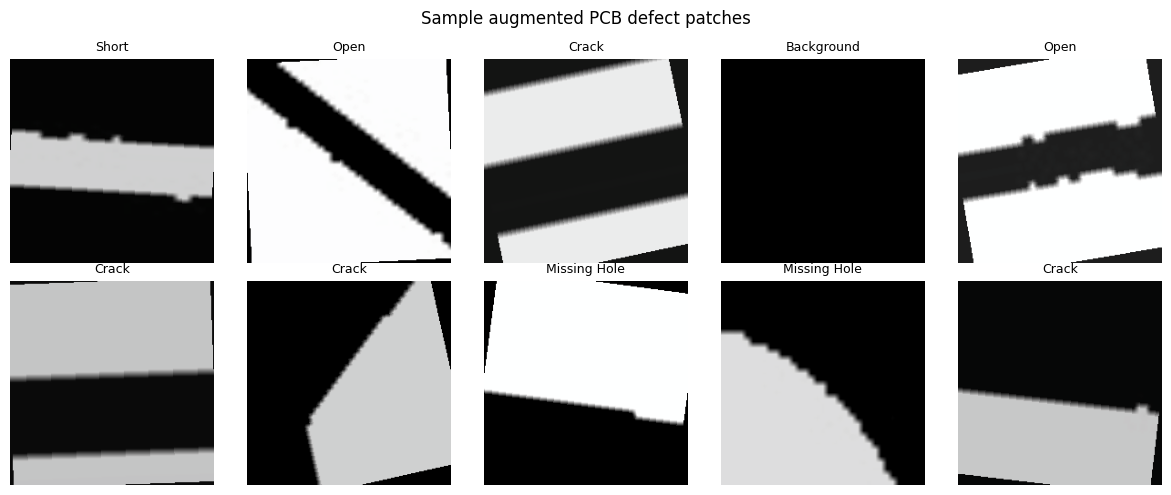

In [3]:
# dataset instantiation and basic checks

from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random

# create training dataset
train_dataset = DeepPCBPatchDataset(
    root_dir=RAW_DATA_ROOT,
    split_file=train_split,
    transform=train_transform
)

# create validation dataset
val_dataset = DeepPCBPatchDataset(
    root_dir=RAW_DATA_ROOT,
    split_file=test_split,
    transform=val_transform
)

print("Training samples:", len(train_dataset))
print("Validation samples:", len(val_dataset))

# dataloaders
BATCH_SIZE = 128  # larger batch since patches are small

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY
)

# quick sanity check on one batch
imgs, labels = next(iter(train_loader))
print("Batch shape:", imgs.shape)
print("Label type:", labels.dtype)
print("Unique labels:", labels.unique())

# visualize a few random samples
class_names = [
    "Open",
    "Short",
    "Crack",
    "Missing Hole",
    "Spur",
    "Background"
]

fig, axes = plt.subplots(2, 5, figsize=(12, 5))

for ax in axes.flatten():
    idx = random.randint(0, len(train_dataset) - 1)
    img, label = train_dataset[idx]

    # convert tensor back to image for display
    img_np = np.transpose(img.numpy(), (1, 2, 0))
    img_np = np.clip(
        img_np * np.array([0.229, 0.224, 0.225]) +
        np.array([0.485, 0.456, 0.406]),
        0, 1
    )

    ax.imshow(img_np)
    ax.set_title(class_names[label.item()], fontsize=9)
    ax.axis("off")

plt.suptitle("Sample augmented PCB defect patches", fontsize=12)
plt.tight_layout()

# save figure inside project folder
figures_dir = Path(
    r"C:\Users\TUSHAR\2025-26\PROJECTS\pcb_defect_detection\results\plots"
)
figures_dir.mkdir(parents=True, exist_ok=True)

plt.savefig(
    figures_dir / "sample_patches.png",
    dpi=300,
    bbox_inches="tight"
)

plt.show()


### Model definition (ResNet-18)

In this cell, a ResNet-18 model pretrained on ImageNet is loaded.
The final classification layer is replaced to match the number of PCB defect
classes. 


In [4]:
import warnings
import torch.nn as nn
from torchvision import models

# suppress torchvision and user warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# number of defect classes
num_classes = 6

# load resnet18 using the recommended weights API
weights = models.ResNet18_Weights.DEFAULT
model = models.resnet18(weights=weights)

# replace final layer
model.fc = nn.Linear(model.fc.in_features, num_classes)

# move model to device
model = model.to(device)

print("ResNet-18 loaded successfully")


ResNet-18 loaded successfully


### Model training

In this step, the ResNet-18 model is trained on the PCB defect patches.
Training loss and validation accuracy are tracked at each epoch to monitor
learning behavior and generalization performance.


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models


In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

print("Loss and optimizer defined")


Loss and optimizer defined


In [7]:
dummy = torch.randn(2, 3, 224, 224).to(device)
out = model(dummy)
print("Output shape:", out.shape)


Output shape: torch.Size([2, 6])


In [8]:
NUM_EPOCHS = 50

train_losses = []
val_accuracies = []

best_val_acc = 0.0
patience = 5
epochs_no_improve = 0

# path to save the best model
MODEL_SAVE_PATH = r"C:\Users\TUSHAR\2025-26\PROJECTS\pcb_defect_detection\models\best_pcb_model.pth"

print("\nStarting training\n")

for epoch in range(NUM_EPOCHS):
    # -------------------------
    # Training phase
    # -------------------------
    model.train()
    running_loss = 0.0

    for imgs, labels in train_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # -------------------------
    # Validation phase
    # -------------------------
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs = imgs.to(device)
            labels = labels.to(device)

            outputs = model(imgs)
            preds = outputs.argmax(dim=1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_acc = correct / total
    val_accuracies.append(val_acc)

    print(
        f"Epoch [{epoch + 1}/{NUM_EPOCHS}] | "
        f"Train Loss: {avg_train_loss:.4f} | "
        f"Val Accuracy: {val_acc:.4f}"
    )

    # -------------------------
    # Early stopping + model saving
    # -------------------------
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        epochs_no_improve = 0

        # save best model
        torch.save(model.state_dict(), MODEL_SAVE_PATH)
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print("Early stopping triggered")
        break

print("\nTraining completed.")
print("Best validation accuracy:", best_val_acc)
print("Best model saved at:", MODEL_SAVE_PATH)



Starting training

Epoch [1/50] | Train Loss: 0.4999 | Val Accuracy: 0.9045
Epoch [2/50] | Train Loss: 0.2375 | Val Accuracy: 0.9280
Epoch [3/50] | Train Loss: 0.2183 | Val Accuracy: 0.9452
Epoch [4/50] | Train Loss: 0.2018 | Val Accuracy: 0.9392
Epoch [5/50] | Train Loss: 0.1879 | Val Accuracy: 0.9328
Epoch [6/50] | Train Loss: 0.1788 | Val Accuracy: 0.9385
Epoch [7/50] | Train Loss: 0.1724 | Val Accuracy: 0.9166
Epoch [8/50] | Train Loss: 0.1620 | Val Accuracy: 0.9306
Early stopping triggered

Training completed.
Best validation accuracy: 0.9452229299363057
Best model saved at: C:\Users\TUSHAR\2025-26\PROJECTS\pcb_defect_detection\models\best_pcb_model.pth


In [15]:
model_path = r"C:\Users\TUSHAR\2025-26\PROJECTS\pcb_defect_detection\models\best_pcb_model.pth"
torch.save(model.state_dict(), model_path)


In [16]:
from sklearn.metrics import classification_report
import numpy as np

model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        outputs = model(imgs)
        preds = outputs.argmax(dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


In [17]:
print(classification_report(all_labels, all_preds))


              precision    recall  f1-score   support

           0       0.96      0.88      0.92       659
           1       0.98      0.96      0.97       478
           2       0.81      0.92      0.86       586
           3       0.94      0.86      0.90       483
           4       0.99      1.00      0.99       464
           5       0.95      0.99      0.97       470

    accuracy                           0.93      3140
   macro avg       0.94      0.93      0.93      3140
weighted avg       0.93      0.93      0.93      3140



## Training and Validation Curves

Training loss shows how well the model learns from the training data, while validation accuracy reflects performance on unseen data. A decreasing training loss and increasing validation accuracy indicate stable learning and good generalization. These curves also help identify overfitting and justify the use of early stopping.


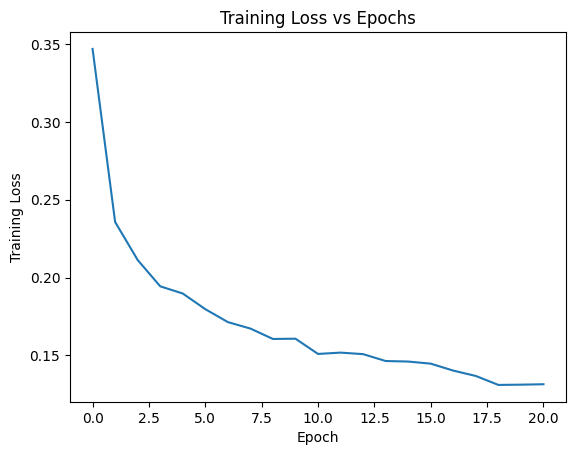

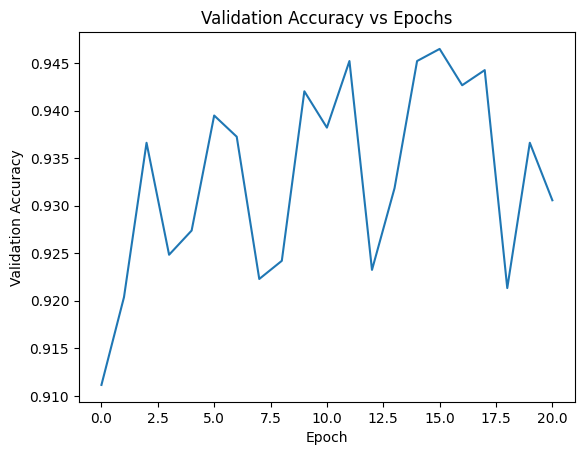

In [18]:
import matplotlib.pyplot as plt

# Training Loss
plt.figure()
plt.plot(train_losses)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss vs Epochs")
plt.show()

# Validation Accuracy
plt.figure()
plt.plot(val_accuracies)
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy vs Epochs")
plt.show()


## ROC Curve

The ROC (Receiver Operating Characteristic) curve shows the trade-off between the True Positive Rate and False Positive Rate at different classification thresholds. It is used to evaluate how well a model separates different classes. A curve closer to the top-left corner indicates better classification performance.


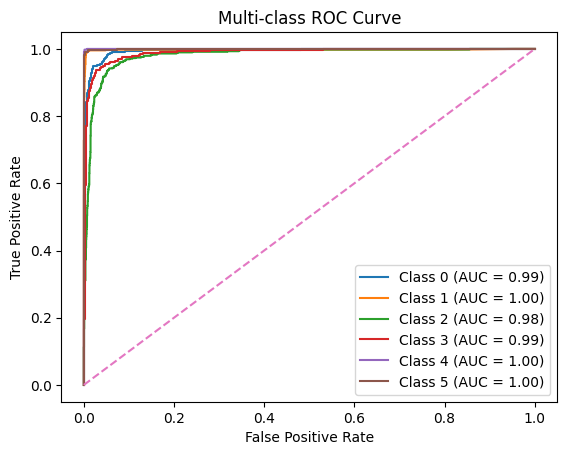

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Number of classes
num_classes = 6

# Binarize labels for multi-class ROC
y_true = label_binarize(all_labels, classes=list(range(num_classes)))

# Get prediction probabilities
model.eval()
all_probs = []

with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        probs = torch.softmax(outputs, dim=1)
        all_probs.append(probs.cpu().numpy())

y_score = np.vstack(all_probs)

# Plot ROC curve for each class
plt.figure()

for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-class ROC Curve")
plt.legend()
plt.show()


## Confusion Matrix

The confusion matrix shows the number of correct and incorrect predictions for each defect class. Rows represent the true labels, while columns represent the predicted labels. It helps identify which defect types are correctly classified and which classes are commonly confused.


<Figure size 600x600 with 0 Axes>

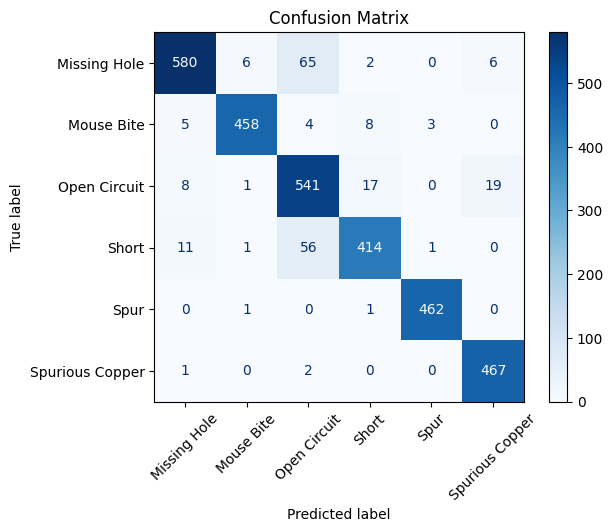

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Class names (update if needed)
class_names = [
    "Missing Hole",
    "Mouse Bite",
    "Open Circuit",
    "Short",
    "Spur",
    "Spurious Copper"
]

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.xticks(rotation=45)
plt.show()
